In [1]:
%matplotlib inline
import pylab as plt
import pandas as pd
import seaborn as sns

In [2]:
diamonds = sns.load_dataset('diamonds')

[info](https://www.kaggle.com/shivam2503/diamonds)

# Explore and Process

In [3]:
diamonds.head(10)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
9,0.23,Very Good,H,VS1,59.4,61.0,338,4.00,4.05,2.39


In [5]:
from utils import plot_corr_matrix

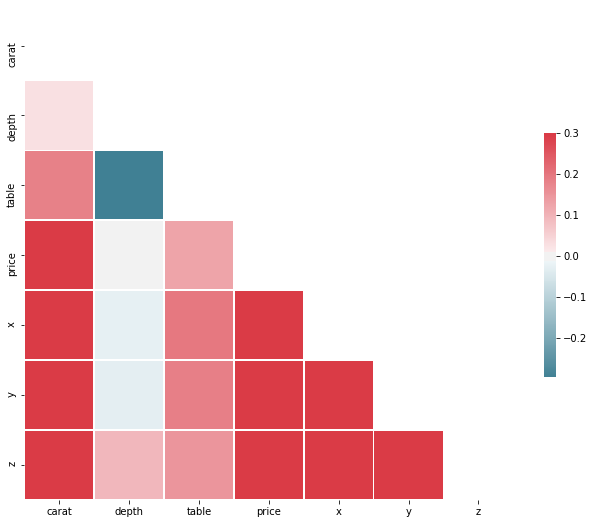

In [6]:
plot_corr_matrix(diamonds)

Сразу заметим что результат выше - только для числовы переменных, а ведь остальные тоже полезные!

# Задача: предсказать цену бриллианта

### Решение - давайте найдем похожий бриллиант в тренировочном сете и возьмем его цену!

- делим датасет на тренировочный и проверочный
- строим модель поиска похожего бриллианта
- измеряем качество модели

- ...PROFIT!

In [7]:
y = diamonds['price']

In [8]:
X = diamonds.drop('price', axis=1).select_dtypes('number')  # только числовые

In [9]:
X.head(10)

,carat,depth,table,x,y,z
0,0.23,61.5,55.0,3.95,3.98,2.43
1,0.21,59.8,61.0,3.89,3.84,2.31
2,0.23,56.9,65.0,4.05,4.07,2.31
3,0.29,62.4,58.0,4.20,4.23,2.63
4,0.31,63.3,58.0,4.34,4.35,2.75
5,0.24,62.8,57.0,3.94,3.96,2.48
6,0.24,62.3,57.0,3.95,3.98,2.47
7,0.26,61.9,55.0,4.07,4.11,2.53
8,0.22,65.1,61.0,3.87,3.78,2.49
9,0.23,59.4,61.0,4.00,4.05,2.39


## I. Делим датасет

"СЛУЧАЙНЫМ" образом!

In [10]:
from sklearn.model_selection import train_test_split

In [12]:
# ?train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=123)

/Users/philippk/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [14]:
X_train.shape

(43152, 6)

In [15]:
X_test.shape

(10788, 6)

## I. Пишем Модель

In [16]:
from sklearn.metrics.pairwise import euclidean_distances

In [24]:
test = pd.DataFrame({'x':[0,1,2,2], 'y':[2,4,6, 7]})
test

,x,y
0,0,2
1,1,4
2,2,6
3,2,7


In [25]:
pd.np.sqrt(1+ 4)

2.23606797749979

In [26]:
euclidean_distances(test.head(2), test.tail(2))

array([[4.47213595, 5.38516481],
       [2.23606798, 3.16227766]])

In [27]:
pd.DataFrame(euclidean_distances(test.head(2), test.tail(2)),
             index=test.head(2).index, columns=test.tail(2).index)

,2,3
0,4.472136,5.385165
1,2.236068,3.162278


In [33]:
def _closest_one(X1, X2):
    matrix = euclidean_distances(X1, X2)
    
    d = pd.DataFrame(matrix,
                 index=X1.index, 
                 columns=X2.index)

    return d.idxmin(axis=1)

In [28]:
class NearestNeighbor:
    X, y = None, None
        
    def fit(self, X, y):
        self.X = X
        self.y = y

    
    def predict(self, X):
        indexes = _closest_one(X, self.X)
        y_pred = self.y[indexes]
        y_pred.index = X.index
        
        return y_pred

#### Let's test it

In [29]:
test_price = pd.Series([1,2,4,4])

In [30]:
model = NearestNeighbor()

In [31]:
model.fit(test.head(3), test_price.head(3))

In [34]:
model.predict(test.iloc[::-1])

3    4
2    4
1    2
0    1
dtype: int64

## How to measure (Regression)

A. Mean absolute error
    + real-world values
    - penalizes small and large errors proportionally 
    - need to be taken in absolute
B. Mean Average Percentage error - same as above, but in percentages of true value

C. Mean Squared error
    - not a real world value
    - penalizes large errors more
D. R^2 - 1 - summ of squared error, divided by summ of the squared deviations from the mean. Best model will have 1

$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=0}^{n_{\text{samples}} - 1} (y_i - \hat{y}_i)^2}{\sum_{i=0}^{n_\text{samples} - 1} (y_i - \bar{y})^2}$$

D. PE_N Percentage of objects with error within N percents of true value

In [35]:
def mean_abs_error(y_pred, y_true):
    return (y_pred - y_true).abs().mean()

In [36]:
def mean_sqr_arror(y_pred, y_true):
    return ((y_pred - y_true) ** 2).mean()

In [37]:
def r_square(y_pred, y_true):
    M = y_true.mean()
    
    return 1 - ((y_true - y_pred)**2).sum() / ((y_true - M)**2).sum()
    
    

In [45]:
def pe10(y_pred, y_true):
    pct_error = (1 - y_pred / y_true).abs()
    return (pct_error <= .1).sum() / len(y_true)

[More on Metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

# Let's Measure our Model

In [39]:
model.fit(X_train, y_train)

In [40]:
y_pred = model.predict(X_test)

In [41]:
y_pred.shape

(10788,)

In [44]:
y_test.std()

3985.261973600158

In [46]:
for metric in (mean_abs_error, mean_sqr_arror, r_square, pe10):
    print(f'{metric.__name__}: {metric(y_pred, y_test)}')

mean_abs_error: 955.0525583982203
mean_sqr_arror: 3108095.784111976
r_square: 0.8042864463171275
pe10: 0.3021876158694846


In [48]:
# definitely correct and usually faster
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [49]:
for metric in  mean_absolute_error, mean_squared_error, r2_score:
     print(f'{metric.__name__}: {metric(y_pred, y_test)}')

mean_absolute_error: 955.0525583982203
mean_squared_error: 3108095.784111976
r2_score: 0.8056968586648982


## Normalisation

In [50]:
from sklearn.preprocessing import Normalizer

In [51]:
N = Normalizer()

In [52]:
N.fit(X_train)

Normalizer(copy=True, norm='l2')

In [58]:
X_train_sc =  pd.DataFrame(N.transform(X_train), index=X_train.index, columns=X_train.columns) 
X_test_sc = pd.DataFrame(N.transform(X_test), index=X_test.index, columns=X_test.columns)

In [59]:
model.fit(X_train_sc, y_train)

In [60]:
y_pred2 = model.predict(X_test_sc)

In [62]:
for metric in  mean_absolute_error, mean_squared_error, r2_score:
     print(f'{metric.__name__}: {metric(y_pred2, y_test)}')

mean_absolute_error: 965.5599740452354
mean_squared_error: 3127339.9685761956
r2_score: 0.8042323833000641
